In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("data_1.8_torque.csv")
# Skip the first 1000 rows
#data = data.iloc[18000:22000]

4860 4860
[  2.73087549   2.73087549   2.73087549 ... 117.76819611 117.76819611
 117.76819611]


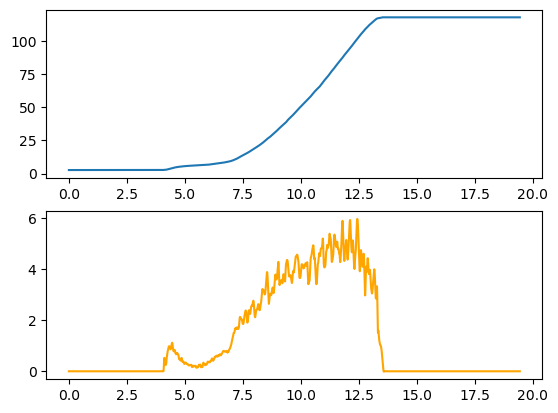

In [6]:
time = np.linspace(0, len(data) * 0.002, num=len(data))
position = np.array(data["/athena/motor_status/rear_left/position"])
motor_velocities = np.array(data["/athena/motor_status/front_left/velocity_low"])
# Delete all entries from time and position where position is NaN
valid_indices = ~np.isnan(position)
time = time[valid_indices]
position = position[valid_indices]
motor_velocities = motor_velocities[valid_indices]
print(len(time), len(position))
print(position)

plt.subplot(211)
plt.plot(time, position, label="Position")
plt.subplot(212)
plt.plot(time, motor_velocities, label="Motor Velocity", color="orange")

## Simple Delta T


Estimating velocity at index 2007
Time: 8.022825478493518s, 8.026825890100843s
Position: 19.235780716, 19.2787323
Delta time: 0.00400041160732556s
Velocity at index 2007: 10.74


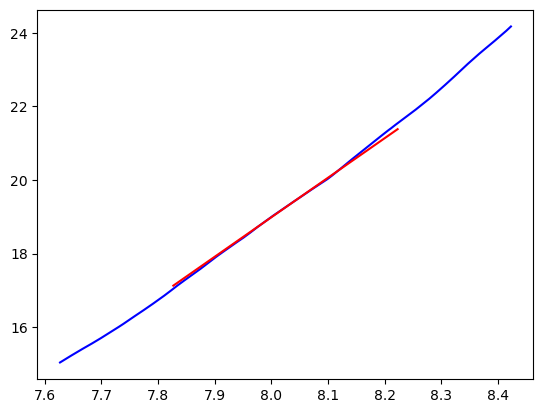

In [7]:
def estimate_velocity(i):
  print(f"Estimating velocity at index {i}")
  print(f"Time: {time[i-1]}s, {time[i]}s")
  print(f"Position: {position[i-1]}, {position[i]}")
  print(f"Delta time: {time[i] - time[i-1]}s")
  return (position[i] - position[i-1]) / (time[i] - time[i-1])

index = 2007
velocity = estimate_velocity(index)
print(f"Velocity at index {index}: {velocity:.2f}")
def velocity_to_line(i):
  return velocity * (time[i] - time[index]) + position[index]

c_pos = 100
c_vel = 50
plt.plot(time[index-c_pos:index+c_pos], position[index-c_pos:index+c_pos], label="Position", color="blue")
plt.plot(time[index-c_vel:index+c_vel], velocity_to_line(np.arange(index-c_vel, index+c_vel)), label="Velocity", color="red")

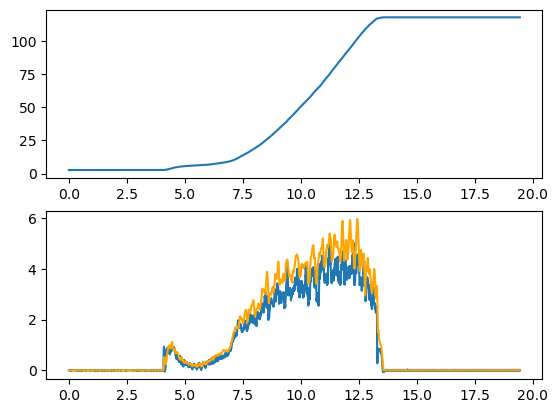

In [9]:
positions = []
times = []
def estimate_velocity(position, time):
    if not np.isnan(position):
        positions.append(position)
        times.append(time)
    if len(positions) < 2:
        return 0.0  # No previous data to calculate velocity
    if len(positions) > 2:
        positions.pop(0)
        times.pop(0)
    if times[-2] >= time:
        raise ValueError("Time must be strictly increasing")
    
    delta_position = positions[-1] - positions[-2]
    delta_time = times[-1] - times[-2]
    if delta_time == 0:
        return 0.0
    velocity = delta_position / delta_time
    return 0.18 * velocity

velocities = [estimate_velocity(pos, t) for pos, t in zip(position, time)]

plt.figure()
plt.subplot(211)
plt.plot(time, position, label="Position")
plt.subplot(212)
plt.plot(time, velocities, label="Estimated Velocity")
plt.plot(time, motor_velocities, label="Motor Velocity", color="orange")
plt.show()

## Averaged over 10 samples

[18.52631187 18.57348251 18.62180328 18.66935539 18.71614265 18.76177788
 18.80703163 18.85113335 18.89523506 18.94048881 18.98535728 19.02907562
 19.07087707 19.11267853 19.15371132 19.19397926 19.23578072 19.2787323
 19.32321739 19.36693573]
Position: 18.851133347, 19.2787323
Delta time: 0.04000411607326537s
Velocity at index 2007: 10.69


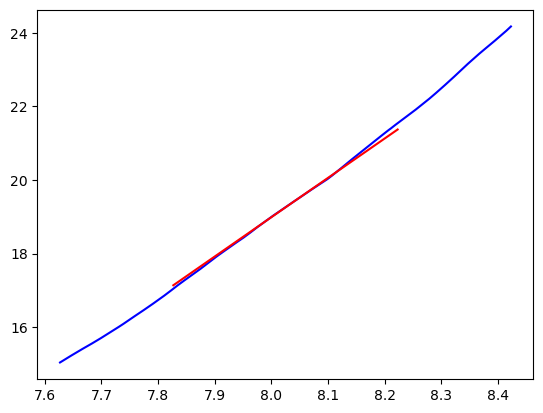

In [10]:
def estimate_velocity(i):
  print(f"Position: {position[i-10]}, {position[i]}")
  print(f"Delta time: {time[i] - time[i-10]}s")
  return (position[i] - position[i-10]) / (time[i] - time[i-10])

print(position[1990:2010])
velocity = estimate_velocity(index)
print(f"Velocity at index {index}: {velocity:.2f}")
def velocity_to_line(i):
  return velocity * (time[i] - time[index]) + position[index]

c_pos = 100
c_vel = 50
plt.plot(time[index-c_pos:index+c_pos], position[index-c_pos:index+c_pos], label="Position", color="blue")
plt.plot(time[index-c_vel:index+c_vel], velocity_to_line(np.arange(index-c_vel, index+c_vel)), label="Velocity", color="red")


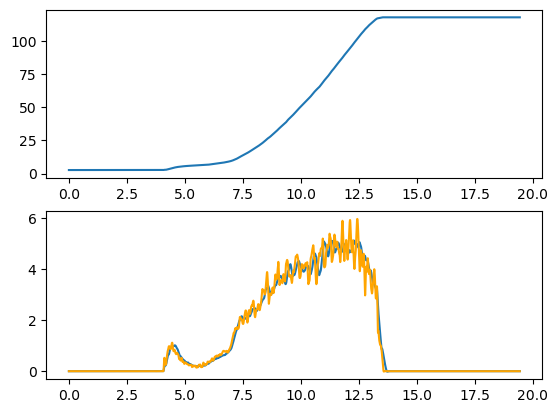

In [11]:
positions = []
times = []
def estimate_velocity(position, time):
    if not np.isnan(position):
        positions.append(position)
        times.append(time)
    if len(positions) < 50:
        return 0.0  # No previous data to calculate velocity
    if len(positions) > 50:
        positions.pop(0)
        times.pop(0)
    if times[-2] >= time:
        raise ValueError("Time must be strictly increasing")
    
    delta_position = positions[-1] - positions[0]
    delta_time = times[-1] - times[0]
    if delta_time == 0:
        return 0.0
    velocity = delta_position / delta_time
    return 0.22 * velocity

velocities = [estimate_velocity(pos, t) for pos, t in zip(position, time)]

plt.figure()
plt.subplot(211)
plt.plot(time, position, label="Position")
plt.subplot(212)
plt.plot(time, velocities, label="Estimated Velocity")
plt.plot(time, motor_velocities, label="Motor Velocity", color="orange")
plt.show()

## PT1

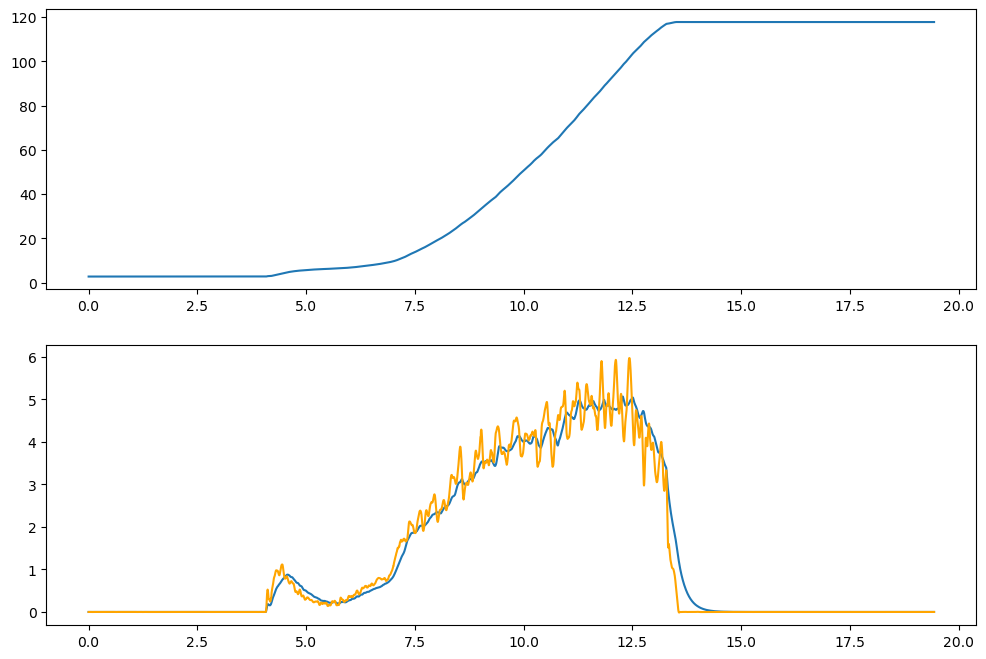

In [29]:
positions = []
times = []
last_time = None
last_position = None
avg_sum = 0.0
count = 0
def estimate_velocity(position, time):
    global last_time, avg_sum, last_position
    if not np.isnan(position):
        if last_time is None:
            last_time = time
            last_position = position
            return 0
        avg_sum -= avg_sum / 50
        avg_sum += (2 / 9.1) * (position - last_position) / (time - last_time)
        last_position = position
        last_time = time
    
    return avg_sum / 50

velocities = [estimate_velocity(pos, t) for pos, t in zip(position, time)]

plt.figure(figsize=(12, 8))
plt.subplot(211)
plt.plot(time, position, label="Position")
plt.subplot(212)
plt.plot(time, velocities, label="Estimated Velocity")
plt.plot(time, motor_velocities, label="Motor Velocity", color="orange")
plt.show()

## Polynomial Fitting

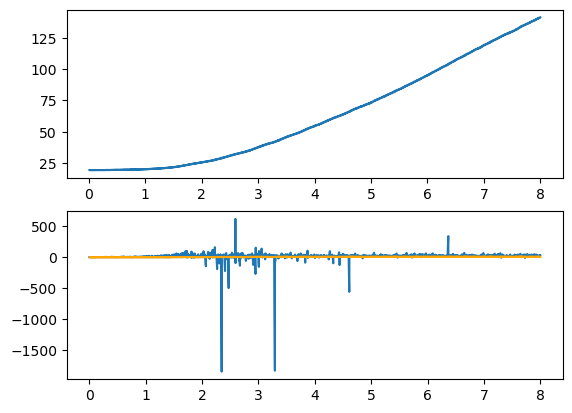

In [104]:
def estimate_velocity_polyfit(index):
    # Gather up to 10 valid (non-missing) points ending at index
    pts = []
    for j in range(index, -1, -1):
        p = position[j]
        if not (p is None or (isinstance(p, float) and (p != p))):  # check for None or NaN
            pts.append((time[j], p))
        if len(pts) == 10:
            break
    if len(pts) < 2:
        return 0.0  # Not enough points

    pts = pts[::-1]  # Oldest to newest
    t_vals = [pt[0] for pt in pts]
    p_vals = [pt[1] for pt in pts]
    n = len(pts)
    degree = min(3, n-1)

    # Build Vandermonde matrix for polynomial fit
    A = []
    for t in t_vals:
        row = [t**d for d in range(degree+1)]
        A.append(row)

    # Solve least squares: (A^T A) c = (A^T p)
    # Compute A^T A and A^T p
    AT = [[A[j][i] for j in range(n)] for i in range(degree+1)]
    ATA = [[sum(AT[i][k] * A[k][j] for k in range(n)) for j in range(degree+1)] for i in range(degree+1)]
    ATp = [sum(AT[i][k] * p_vals[k] for k in range(n)) for i in range(degree+1)]

    # Solve ATA * c = ATp using Gaussian elimination
    c = ATp[:]
    for i in range(degree+1):
        # Normalize row i
        factor = ATA[i][i]
        if factor == 0:
            return 0.0
        for j in range(i, degree+1):
            ATA[i][j] /= factor
        c[i] /= factor
        # Eliminate column i from lower rows
        for k in range(i+1, degree+1):
            f = ATA[k][i]
            for j in range(i, degree+1):
                ATA[k][j] -= f * ATA[i][j]
            c[k] -= f * c[i]
    # Back substitution
    for i in range(degree, -1, -1):
        for k in range(i-1, -1, -1):
            c[k] -= ATA[k][i] * c[i]

    # Derivative of polynomial at time[index]
    t0 = time[index]
    velocity = 0.0
    for d in range(1, degree+1):
        velocity += d * c[d] * (t0 ** (d-1))
    return velocity

velocities = [estimate_velocity_polyfit(index) for index in range(len(position))]

plt.figure()
plt.subplot(211)
plt.plot(time, position, label="Position")
plt.subplot(212)
plt.plot(time, velocities, label="Estimated Velocity")
plt.plot(time, motor_velocities, label="Motor Velocity", color="orange")
plt.show()